## Exercise 2

In [23]:
import numpy as np
import matplotlib.pyplot as plt

In [24]:
nodes = ['o', 'a', 'b', 'c', 'd']
node_idx = {n: i for i, n in enumerate(nodes)}
num_nodes = len(nodes)

# Transition matrix Lambda
Lambda = np.zeros((num_nodes, num_nodes))

# o -> a (2/5), o -> b (1/5)
Lambda[node_idx['o'], node_idx['a']] = 0.4
Lambda[node_idx['o'], node_idx['b']] = 0.2

# a -> b (3/4), a -> c (1/4)
Lambda[node_idx['a'], node_idx['b']] = 0.75
Lambda[node_idx['a'], node_idx['c']] = 0.25

# b -> o (1/2), b -> c (1/3)
Lambda[node_idx['b'], node_idx['o']] = 0.5
Lambda[node_idx['b'], node_idx['c']] = 1/3

# c -> b (1/3), c -> d (2/3)
Lambda[node_idx['c'], node_idx['b']] = 1/3
Lambda[node_idx['c'], node_idx['d']] = 2/3

# d -> a (1/3), d -> c (1/3)
Lambda[node_idx['d'], node_idx['a']] = 1/3
Lambda[node_idx['d'], node_idx['c']] = 1/3

# omega contains the rate of total exit for each node
omega = np.sum(Lambda, axis=1)
omega_star = np.max(omega)  # max exit rate for global uniformization

# Local jump probability matrix
P = np.linalg.inv(np.diag(omega)) @ Lambda

# solve for stationary distribution pi:  pi * P = pi
values,vectors = np.linalg.eig(P.T)
index = np.argmax(values.real)
pi = vectors[:,index].real
# local stationary distribution
pi = pi/np.sum(pi)

# Global jump probability matrix (uniformization)
P_bar = np.zeros_like(Lambda)
P_bar = Lambda / omega_star
for i in range(num_nodes):
    P_bar[i, i] = 1.0 - np.sum(P_bar[i, :])

# global stationary distribution
pi_bar = (pi / omega) / np.sum(pi / omega)

print("Exit rates (omega):", dict(zip(nodes, np.round(omega, 3))))
print("Stationary distribution (pi):", dict(zip(nodes, np.round(pi, 3))))
print("Stationary distribution (pi_bar):", dict(zip(nodes, np.round(pi_bar, 3))))
expected_return_a = 1 / (pi_bar[node_idx['a']] * omega[node_idx['a']]) # Kac's formula for continuous-time
print(f"Theoretical expected return time for 'a': {expected_return_a:.4f}")

Exit rates (omega): {'o': np.float64(0.6), 'a': np.float64(1.0), 'b': np.float64(0.833), 'c': np.float64(1.0), 'd': np.float64(0.667)}
Stationary distribution (pi): {'o': np.float64(0.162), 'a': np.float64(0.185), 'b': np.float64(0.269), 'c': np.float64(0.231), 'd': np.float64(0.154)}
Stationary distribution (pi_bar): {'o': np.float64(0.217), 'a': np.float64(0.149), 'b': np.float64(0.261), 'c': np.float64(0.186), 'd': np.float64(0.186)}
Theoretical expected return time for 'a': 6.7083


In [25]:
# Particle perspective simulation

def simulate_particle_return_time(start_node_idx, n_particles):

    return_times = []

    # since particles do not interact, we can simulate them independently, statistically the results will be the same
    for _ in range(n_particles * 10000):
        current_node = start_node_idx
        time_elapsed = 0.0
        
        while True:
            # local clock
            rate = omega[current_node]
            dt = np.random.exponential(1/rate) # equivalent to -np.log(np.random.rand()) / rate
            time_elapsed += dt
            
            next_node = np.random.choice(num_nodes, p=P[current_node]) # local jump matrix
            
            current_node = next_node
            
            
            if current_node == start_node_idx:
                return_times.append(time_elapsed)
                break
                
    return np.array(return_times)

N_particles = 100
return_times = simulate_particle_return_time(node_idx['a'], N_particles)
avg_return_time = np.mean(return_times)
print(f"Number of particles: {N_particles}")
print(f"Average return time simulated (start a -> ... -> a): {avg_return_time:.4f}")
print(f"Comparison with theoretical ({expected_return_a:.4f}): {'Close' if abs(avg_return_time - expected_return_a) < 1.0 else 'Distant'}")


Number of particles: 100
Average return time simulated (start a -> ... -> a): 6.7087
Comparison with theoretical (6.7083): Close


In [26]:
def simulate_particles_system_wide_clock(N_particles, start_node_label):
    start_idx = node_idx[start_node_label]
    
    # system state: positions of all particles
    positions = np.full(N_particles, start_idx, dtype=int)
    
    # the particle has left the starting node
    has_left = np.full(N_particles, False, dtype=bool)
    
    # the particle has returned
    finished = np.full(N_particles, False, dtype=bool)
    
    return_times = np.zeros(N_particles)
    
    current_time = 0.0
    count_finished = 0
    
    # global clock
    global_rate = N_particles * omega_star
    
    while count_finished < N_particles:
        
        dt = np.random.exponential(1 / global_rate)
        current_time += dt
        
        # randomly select a particle to move
        # a particle could be selected even if it has finished in order to not alter the system, but it won't affect the return time
        p_idx = np.random.randint(0, N_particles)
        
        curr_node = positions[p_idx]
        
        # jump based on global jump matrix
        next_node = np.random.choice(num_nodes, p=P_bar[curr_node])
        
        positions[p_idx] = next_node
        
        if not finished[p_idx]:
            
            # left if no self-jump
            if curr_node == start_idx and next_node != start_idx:
                has_left[p_idx] = True
            
            # check if returned to start and has left
            if next_node == start_idx and has_left[p_idx]:
                return_times[p_idx] = current_time
                finished[p_idx] = True
                count_finished += 1

    return return_times

N_particles = 100
return_times = [np.mean(simulate_particles_system_wide_clock(N_particles, 'a')) for _ in range(10000)]
avg_return_time = np.mean(return_times)
print(f"Number of particles: {N_particles}")
print(f"Average return time simulated (start a -> ... -> a): {avg_return_time:.4f}")
print(f"Comparison with theoretical ({expected_return_a:.4f}): {'Close' if abs(avg_return_time - expected_return_a) < 1.0 else 'Distant'}")

Number of particles: 100
Average return time simulated (start a -> ... -> a): 6.7099
Comparison with theoretical (6.7083): Close


In [35]:
# Node perspective simulation
def simulate_node_perspective_with_global_clock(start_dist, total_time, n_particles=100, method='uniformization'):

    counts = np.array(start_dist, dtype=int)
    current_time = 0.0
    
    # plotting variables
    times = [0.0]
    history = [counts.copy()]

    if method == 'uniformization':
        # global fixed clock rate
        total_system_rate = n_particles * omega_star
    
    while True:
        
        if method == 'gillespie':
            node_rates = counts * omega
            # global variable clock rate
            total_system_rate = np.sum(node_rates)
            
        # time to next event (global exponential)
        dt = np.random.exponential(1 / total_system_rate)
        current_time += dt
        
        if current_time > total_time:
            break

        # choose which node moves a particle (proportional to particles number)
        if method == 'gillespie':
            # choose node that moves proportionally to its rate. nodes with higer rates more likely to move
            source_node = np.random.choice(num_nodes, p=node_rates/np.sum(node_rates))  
            # use P to choose where the particle jumps
            target_node = np.random.choice(num_nodes, p=P[source_node]) # Gillespie simulates just real events when a particle effectively leave
        
        if method == 'uniformization':
            source_node = np.random.choice(num_nodes, p=counts/n_particles)
            # use P_bar to choose where the particle jumps
            target_node = np.random.choice(num_nodes, p=P_bar[source_node])
        
        # update states
        counts[source_node] -= 1
        counts[target_node] += 1
        
        times.append(current_time)
        history.append(counts.copy())
        
    return np.array(times), np.array(history)

initial_counts = [0, 100, 0, 0, 0] # every particle starts in 'a'
T_max = 60
times, history = simulate_node_perspective_with_global_clock(initial_counts, T_max, N_particles, method='uniformization')
times_gill, history_gill = simulate_node_perspective_with_global_clock(initial_counts, T_max, N_particles, method='gillespie')

final_counts = history[-1]
final_counts_gill = history_gill[-1]
expected_counts = pi_bar * 100 # use stationary distribution that account for times also. pi_bar means percentage of particles at each node at stationarity

total time unit for the whole simulation=60:
6107 time steps recorded
Simulated final counts global fixed clock
{'o': np.int64(28), 'a': np.int64(18), 'b': np.int64(19), 'c': np.int64(18), 'd': np.int64(17)}
Theoretical stationary expected counts (N * pi_bar):
{'o': np.float64(21.7), 'a': np.float64(14.9), 'b': np.float64(26.1), 'c': np.float64(18.6), 'd': np.float64(18.6)}
Time Average Counts
{'o': np.float64(23.0), 'a': np.float64(15.0), 'b': np.float64(26.0), 'c': np.float64(18.0), 'd': np.float64(17.0)}


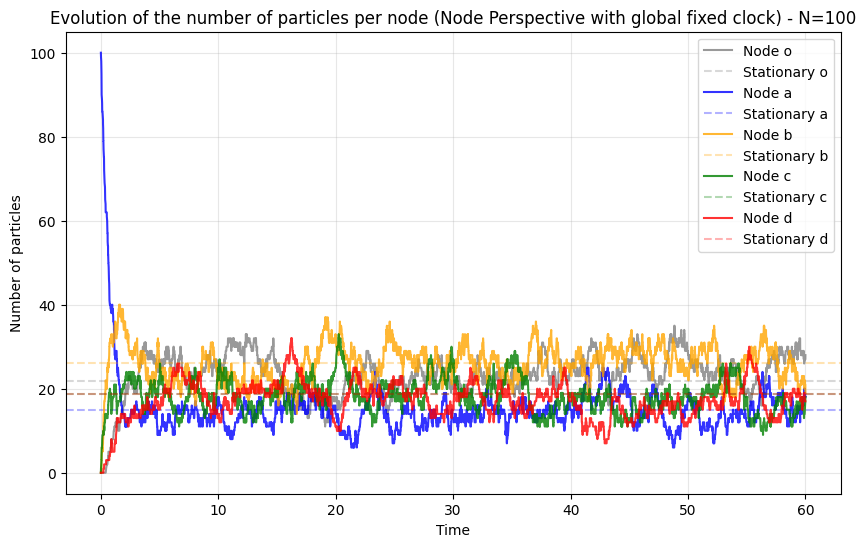

In [36]:
print(f"total time unit for the whole simulation={T_max}:")
print(f"{len(times)} time steps recorded")
print(f"Simulated final counts global fixed clock")
print(dict(zip(nodes, final_counts)))
print("Theoretical stationary expected counts (N * pi_bar):")
print(dict(zip(nodes, np.round(expected_counts, 1))))


history_arr = np.array(history)

# time average count (without initial transient)
time_averaged_counts = np.mean(history_arr[10:], axis=0) # discard first 10 steps of transient

print("Time Average Counts")
print(dict(zip(nodes, np.round(time_averaged_counts, 0))))

plt.figure(figsize=(10, 6))
colors = ['gray', 'blue', 'orange', 'green', 'red']
for i in range(num_nodes):
    plt.plot(times, history[:, i], label=f'Node {nodes[i]}', color=colors[i], alpha=0.8)
    plt.axhline(y=expected_counts[i], color=colors[i], linestyle='--', alpha=0.3, label=f'Stationary {nodes[i]}')


plt.title(f'Evolution of the number of particles per node (Node Perspective with global fixed clock) - N={sum(initial_counts)}')
plt.xlabel('Time')
plt.ylabel('Number of particles')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.savefig('node_perspective_simulation_global_clock.pdf')
plt.show()

total time unit for the whole simulation=60):
4858 time steps recorded
Simulated final counts global variable clock
{'o': np.int64(28), 'a': np.int64(14), 'b': np.int64(23), 'c': np.int64(21), 'd': np.int64(14)}
Theoretical stationary expected counts (N * pi_bar):
{'o': np.float64(21.7), 'a': np.float64(14.9), 'b': np.float64(26.1), 'c': np.float64(18.6), 'd': np.float64(18.6)}
Time Average Counts
{'o': np.float64(23.0), 'a': np.float64(16.0), 'b': np.float64(26.0), 'c': np.float64(18.0), 'd': np.float64(17.0)}


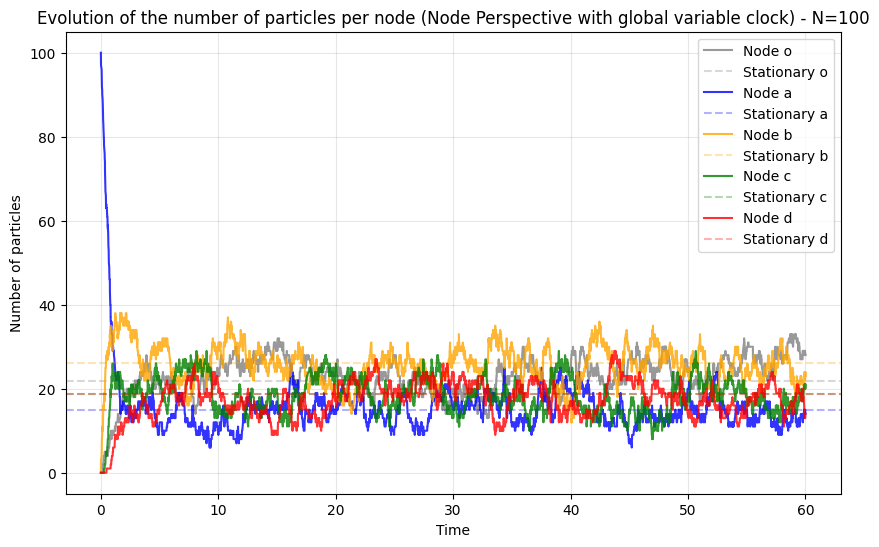

In [37]:
print(f"total time unit for the whole simulation={T_max}):")
print(f"{len(times_gill)} time steps recorded")
print(f"Simulated final counts global variable clock")
print(dict(zip(nodes, final_counts_gill)))
print("Theoretical stationary expected counts (N * pi_bar):")
print(dict(zip(nodes, np.round(expected_counts, 1))))


history_arr = np.array(history_gill)

# time average count (without initial transient)
time_averaged_counts = np.mean(history_arr[10:], axis=0) # discard first 10 steps of transient

print("Time Average Counts")
print(dict(zip(nodes, np.round(time_averaged_counts, 0))))

plt.figure(figsize=(10, 6))
colors = ['gray', 'blue', 'orange', 'green', 'red']
for i in range(num_nodes):
    plt.plot(times_gill, history_gill[:, i], label=f'Node {nodes[i]}', color=colors[i], alpha=0.8)
    plt.axhline(y=expected_counts[i], color=colors[i], linestyle='--', alpha=0.3, label=f'Stationary {nodes[i]}')


plt.title(f'Evolution of the number of particles per node (Node Perspective with global variable clock) - N={sum(initial_counts)}')
plt.xlabel('Time')
plt.ylabel('Number of particles')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.savefig('node_perspective_simulation_local_clock.pdf')
plt.show()

## Local Clocks

La "Race Condition": Nel codice vedi il ciclo for i in range(num_nodes). Qui stiamo simulando esplicitamente che ogni nodo ha il suo orologio
- Il Nodo A dice: "Io spedirò una particella tra 0.5 secondi".
- Il Nodo B dice: "Io spedirò una particella tra 0.2 secondi".
- Risultato: Vince il Nodo B. Il tempo avanza di 0.2. L'evento di A viene scartato (o ricalcolato al turno dopo).

Inefficienza Computazionale: Come puoi vedere, generiamo num_nodes (5) numeri casuali ad ogni singolo passo, per poi usarne solo uno (il minimo).
- Nel metodo Gillespie generavamo 1 solo numero casuale per il tempo.
- Nel metodo Uniformization generavamo 1 solo numero casuale per il tempo. 

Ecco perché il testo del problema presentava questa opzione come quella problematica ("it would have to change rate" ): dover rigenerare o aggiornare costantemente 5 orologi è più costoso che gestirne uno centralizzato

Equivalenza Matematica: Nonostante l'inefficienza, la proprietà del minimo di variabili esponenziali garantisce che questo metodo produca risultati statisticamente identici al metodo Gillespie. Infatti: $min(Exp(λ1​),Exp(λ2​))∼Exp(λ1​+λ2​)$. Il tempo min_delay che calcoliamo qui segue esattamente la stessa distribuzione del dt calcolato nel metodo Gillespie con la somma dei tassi

60 time unit
4846 time steps recorded
Final counts at time t=59.99):
{'o': np.int64(19), 'a': np.int64(12), 'b': np.int64(34), 'c': np.int64(16), 'd': np.int64(19)}


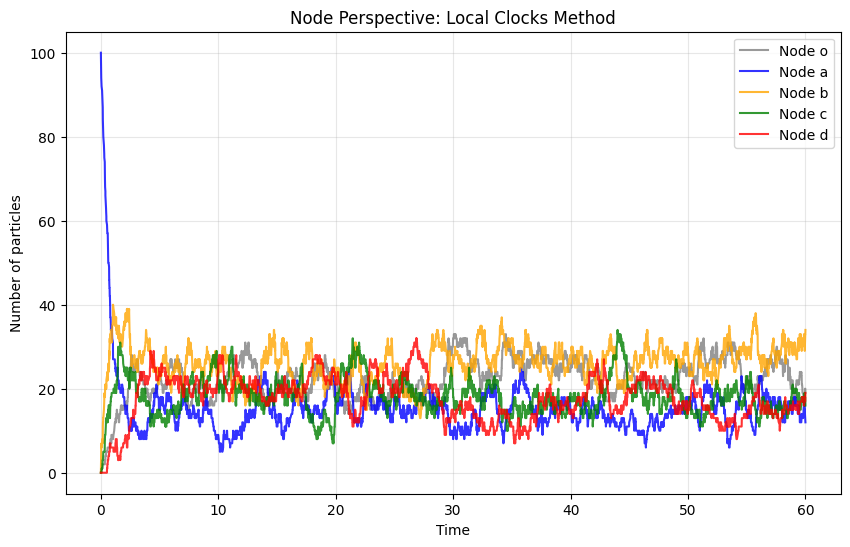

In [38]:
def simulate_node_perspective_with_local_clocks(start_dist, total_time):
    counts = np.array(start_dist, dtype=int)
    current_time = 0.0
    
    times = [0.0]
    history = [counts.copy()]
    
    while True:
        # rate_i = n_i * omega_i
        current_rates = counts * omega
        
        # Local Clocks
        # each node proposes a waiting time (dt) based on its current rate.
        # if rate is 0 (empty node), time is infinite.
        proposed_delays = np.full(num_nodes, np.inf)
        
        for i in range(num_nodes):
            if current_rates[i] > 0:
                # exponential local time for node i
                proposed_delays[i] = np.random.exponential(1.0 / current_rates[i])
        
        # first reaction move the particle
        min_delay = np.min(proposed_delays)
        
        # Se tutti i delay sono infiniti (sistema vuoto o bloccato), usciamo
        if min_delay == np.inf:
            break
            
        current_time += min_delay
        
        if current_time > total_time:
            break
            
        # first reaction move the particle
        source_node = np.argmin(proposed_delays)
        
        target_node = np.random.choice(num_nodes, p=P[source_node])
        
        counts[source_node] -= 1
        counts[target_node] += 1
        
        times.append(current_time)
        history.append(counts.copy())
        
    return np.array(times), np.array(history)


initial_counts = [0, 100, 0, 0, 0]
T_max = 60

times, history = simulate_node_perspective_with_local_clocks(initial_counts, T_max)

final_counts = history[-1]
print(f"{T_max} time unit")
print(f"{len(times)} time steps recorded")
print(f"Final counts at time t={times[-1]:.2f}):")
print(dict(zip(nodes, final_counts)))

plt.figure(figsize=(10, 6))
colors = ['gray', 'blue', 'orange', 'green', 'red']
for i in range(num_nodes):
    plt.plot(times, history[:, i], label=f'Node {nodes[i]}', color=colors[i], alpha=0.8)

plt.title('Node Perspective: Local Clocks Method')
plt.xlabel('Time')
plt.ylabel('Number of particles')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()